# Yield curves
This notebook constructs and visualizes current and historical US Treasury Yield curves for maturities up to 30 Years. I use cubic splines to interpolate the curve, conviniently provided by SciPy's [InterpolatedUnivariateSpline class](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.InterpolatedUnivariateSpline.html). 

For more details on cubic spining please refer to [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf).

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
import matplotlib.ticker as mtick

from dateutil.relativedelta import relativedelta
from datetime import date

from pricing import curves, par_yield_converter

In [2]:
report_start = date.fromisoformat('2012-01-01')
report_end = date.today()

### Get US Treasury Yields and convert them into Zero rates
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `DFF` &mdash; Federal Funds Effective Rate (daily frequency, from 1954)
* `DGS1MO` &mdash; Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS3MO` &mdash; Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS6MO` &mdash; Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS1` &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS2` &mdash; Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS3` &mdash; Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS5` &mdash; Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS7` &mdash; Market Yield on U.S. Treasury Securities at 7-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS10` &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS20` &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* `DGS30` &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)

In [3]:
today = date.today()

# Constructing the riskless yield curve based on the current fed funds rate and treasury yields
data = web.get_data_fred(
    ['DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'],
    today - BDay(3), today)
data.dropna(inplace=True)

cur_date_curve = data.index[-1].date()

# Convert to percentage points
data /= 100.

# Some adjustments are required to bring FED Funds rate to the same day count convention and compounding frequency
# as treasury yields (actual/actual with semi-annual compounding):
# 1. https://www.federalreserve.gov/releases/h15/default.htm -> day count convention for Fed Funds Rate needs
# to be changed to actual/actual
# 2. Conversion to APY: https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions
data.DFF *= (366 if curves.YieldCurve.is_leap_year(cur_date_curve.year) else 365) / 360 # to x/actual
data.DFF = 2 * (np.sqrt(data.DFF + 1) - 1)

maturities = [0, 1/12, .25, .5, 1, 2, 3, 5, 7, 10, 20, 30]
offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20),
           relativedelta(years=+30)]

spot_rates_dict = par_yield_converter.par_yields_to_spot(data.loc[pd.Timestamp(cur_date_curve)], maturities, 2)
spot_rates = np.asarray([spot_rates_dict[maturity] for maturity in maturities], dtype=np.float64)

# Define the riskless yield curve
curve_ = curves.YieldCurve(today, offsets, data.loc[pd.Timestamp(cur_date_curve)], compounding_freq=2)

# Define the riskless spot rate curve
curve = curves.YieldCurve(today, offsets, spot_rates, compounding_freq=2)

### Constructing curve points for today's treasury yield curve and its corresponding zero rates curve

In [4]:
curve_points = curve.get_curve_points(120)
curve_points_ = curve_.get_curve_points(120)

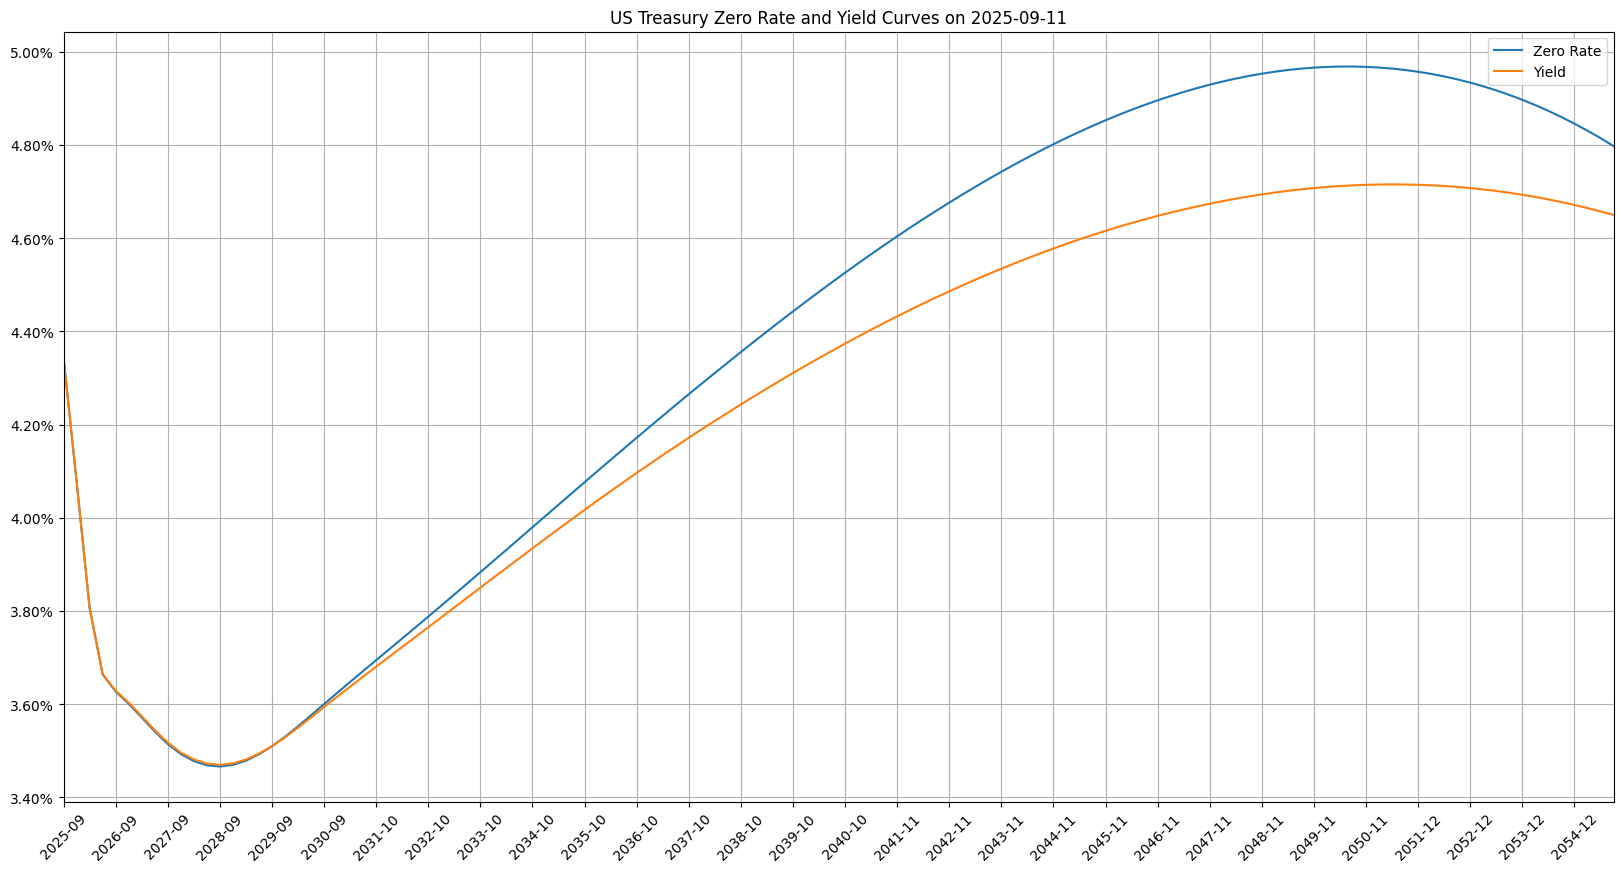

In [5]:
ax = curve_points.plot(figsize=(20,10), grid=True, xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
curve_points_.plot(figsize=(20,10), grid=True, xlim=(curve_points_.index[0], curve_points.index[-1]),
                   xticks=curve_points_.index[::4], xlabel='', rot=45)
ax.set_title('US Treasury Zero Rate and Yield Curves on ' + cur_date_curve.strftime('%Y-%m-%d'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
h, _ = ax.get_legend_handles_labels()
ax.legend(h, ['Zero Rate', 'Yield'])
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))

## Principle Component Analysis (PCA)
Unfortunately the explanation of the PCA in the textbook leaves a lot to be desired. In this section of the notebook I make an attempt at clarifying it using the data from the textbook.

In principle component analysis the goal is to reduce the dimensions of the data set `X`, model the reduced factors `Z`, get the forecasted values, and map them back to `X` through their eigen vectors.
 
In this case `X` is the co-movement of swap rates using a spectral decomposition we have:
$$C_x=W\cdot\Lambda\cdot{W^T}$$
where:
C<sub>x</sub> = the covariance matrix of the swap rates movements.
&Lambda; = the covariance matrix of the factors (which are independent, hence this is the diagonal matrix of variances of each component, or the values in table 9.8 squared)
W = the matrix of eigen vectors (factor loadings) which relate the movements of the factors to the swap rates (table 9.7).
 
This leaves up with a set of swap rate movements `X` and factor movements `Z`:

$$X \sim N(0, C_x)\quad\&\quad{Z} \sim N(0, \sqrt{\lambda})$$
 
Which are related through equation:
$$X = W\cdot{Z}$$

Table 9.7 is `W` and Table 9.8 is $\sqrt{\lambda}$.

In [330]:
# table 9.7
W = np.array([
    [0.216, -0.501, 0.627, -0.487, 0.122, 0.237, 0.011, -0.034],
    [0.331, -0.429, 0.129, 0.354, -0.212, -0.674, -0.100, 0.236],
    [0.372, -0.267, -0.157, 0.414, -0.096, 0.311, 0.413, -0.564],
    [0.392, -0.110, -0.256, 0.174, -0.019, 0.551, -0.416, 0.512],
    [0.404, 0.019, -0.355, -0.269, 0.595, -0.278, -0.316, -0.327],
    [0.394, 0.194, -0.195, -0.336, 0.007, -0.100, 0.685, 0.422],
    [0.376, 0.371, 0.068, -0.305, -0.684, -0.039, -0.278, -0.279],
    [0.305, 0.554, 0.575, 0.398, 0.331, 0.022, 0.007, 0.032]
])

# table 9.8
sqrt_lamda = np.array([17.55, 4.77, 2.08, 1.29, 0.91, 0.73, 0.56, 0.53])

# Obtain the covariance matrix of the swap rates movements
C_X = np.dot(np.dot(W, np.power(np.diag(sqrt_lamda), 2)), W.T)

# Apply the spectral composition on C_X
eigenvalues, eigenvectors = np.linalg.eig(C_X)

# difference between the values in Tables 9.7 and 9.8 and values obtained from the covariance matrix of swap rate movements
print("Are they within 2%-10% of each other:")
print(np.allclose(W[:4,:4], eigenvectors[:4,:4], rtol=1e-1))
print(np.allclose(sqrt_lamda, np.sqrt(eigenvalues), rtol=2e-2))

Are they within 2%-10% of each other:
False
False


In [331]:
W

array([[ 0.216, -0.501,  0.627, -0.487,  0.122,  0.237,  0.011, -0.034],
       [ 0.331, -0.429,  0.129,  0.354, -0.212, -0.674, -0.1  ,  0.236],
       [ 0.372, -0.267, -0.157,  0.414, -0.096,  0.311,  0.413, -0.564],
       [ 0.392, -0.11 , -0.256,  0.174, -0.019,  0.551, -0.416,  0.512],
       [ 0.404,  0.019, -0.355, -0.269,  0.595, -0.278, -0.316, -0.327],
       [ 0.394,  0.194, -0.195, -0.336,  0.007, -0.1  ,  0.685,  0.422],
       [ 0.376,  0.371,  0.068, -0.305, -0.684, -0.039, -0.278, -0.279],
       [ 0.305,  0.554,  0.575,  0.398,  0.331,  0.022,  0.007,  0.032]])

In [332]:
np.round(eigenvectors,3)

array([[ 0.216, -0.501,  0.627,  0.487,  0.122,  0.237,  0.034,  0.012],
       [ 0.331, -0.429,  0.129, -0.354, -0.211, -0.674, -0.236, -0.1  ],
       [ 0.372, -0.267, -0.157, -0.414, -0.097,  0.311,  0.565,  0.412],
       [ 0.392, -0.11 , -0.256, -0.174, -0.02 ,  0.551, -0.513, -0.414],
       [ 0.404,  0.019, -0.355,  0.269,  0.595, -0.277,  0.327, -0.317],
       [ 0.394,  0.194, -0.195,  0.336,  0.008, -0.101, -0.419,  0.686],
       [ 0.376,  0.371,  0.068,  0.305, -0.683, -0.04 ,  0.278, -0.279],
       [ 0.305,  0.554,  0.575, -0.398,  0.33 ,  0.023, -0.032,  0.007]])

In [333]:
sqrt_lamda

array([17.55,  4.77,  2.08,  1.29,  0.91,  0.73,  0.56,  0.53])

In [334]:
np.round(np.sqrt(eigenvalues),2)

array([17.56,  4.77,  2.08,  1.29,  0.91,  0.73,  0.53,  0.56])

Looks like Table 9.7 in the text book has the last two columns in the wrong order. Also some values have a wrong sign... Let's correct it.

In [335]:
W[:-2, [-2, -1]] = W[:-2, [-1, -2]]
W[-1, [-2, -1]] = W[-1, [-1, -2]]
W[:, [3, 5, 6]] *= -1  # all true!

Let's now see whether spectral decomposition results in the same eigenvectors as `W`

In [336]:
# Obtain the covariance matrix of the swap rates movements
C_X = np.dot(np.dot(W, np.power(np.diag(sqrt_lamda), 2)), W.T)

# Apply the spectral composition on C_X
eigenvalues, eigenvectors = np.linalg.eig(C_X)

print("Are they within 2-10% of each other now:")
print(np.allclose(W, eigenvectors, rtol=1e-1))
print(np.allclose(sqrt_lamda, np.sqrt(eigenvalues), rtol=2e-2))

Are they within 2-10% of each other now:
True
True


In [337]:
np.round(eigenvectors,3)

array([[ 0.216, -0.501,  0.627,  0.487,  0.122, -0.237,  0.034,  0.012],
       [ 0.331, -0.429,  0.129, -0.354, -0.212,  0.674, -0.235, -0.101],
       [ 0.372, -0.267, -0.157, -0.414, -0.096, -0.311,  0.563,  0.415],
       [ 0.392, -0.11 , -0.256, -0.174, -0.02 , -0.551, -0.511, -0.417],
       [ 0.404,  0.019, -0.355,  0.269,  0.595,  0.277,  0.328, -0.316],
       [ 0.394,  0.194, -0.195,  0.336,  0.008,  0.101, -0.423,  0.684],
       [ 0.376,  0.371,  0.068,  0.305, -0.683,  0.04 ,  0.28 , -0.277],
       [ 0.305,  0.554,  0.575, -0.398,  0.33 , -0.023, -0.032,  0.007]])

In [338]:
W

array([[ 0.216, -0.501,  0.627,  0.487,  0.122, -0.237,  0.034,  0.011],
       [ 0.331, -0.429,  0.129, -0.354, -0.212,  0.674, -0.236, -0.1  ],
       [ 0.372, -0.267, -0.157, -0.414, -0.096, -0.311,  0.564,  0.413],
       [ 0.392, -0.11 , -0.256, -0.174, -0.019, -0.551, -0.512, -0.416],
       [ 0.404,  0.019, -0.355,  0.269,  0.595,  0.278,  0.327, -0.316],
       [ 0.394,  0.194, -0.195,  0.336,  0.007,  0.1  , -0.422,  0.685],
       [ 0.376,  0.371,  0.068,  0.305, -0.684,  0.039,  0.278, -0.279],
       [ 0.305,  0.554,  0.575, -0.398,  0.331, -0.022, -0.032,  0.007]])

In [346]:
# Simulate the independent factors Z
np.random.seed(42)
random_variables = np.random.normal(loc=0, scale=1, size=(8, 32000))
Z = np.sqrt(eigenvalues)[:,np.newaxis] * random_variables

# use the eigen eigenvectors to get the approximated swap curve changes X (equation (1) first email)
X = np.dot(eigenvectors, Z)

In [349]:
# estimate the covariance matrix on the simulations
estimate_covariance_matrix = np.cov(X)

In [354]:
# difference between the covariance matrix and the estimated from the factor is all < 1%
print("Covariance Matrix C_X Hull:")
print(C_X)
print("=============================")
print("Estimated Covariance Matrix from factor simulations:")
print(estimate_covariance_matrix)
print("=============================")
print("are they within 70bps of each other:")
print(np.allclose(C_X, estimate_covariance_matrix, rtol=7e-3))

Covariance Matrix C_X Hull:
[[22.21932594 26.86488181 27.06767453 26.55857411 25.94346698 23.72982663
  21.14533743 15.24917511]
 [26.86488181 38.51263942 40.53921812 40.85228534 40.62534365 38.01411884
  34.69106001 26.17833116]
 [27.06767453 40.53921812 44.84335309 45.83018123 46.15726439 43.85342451
  40.63549263 31.43651614]
 [26.55857411 40.85228534 45.83018123 48.2310312  48.93891132 47.16174666
  44.29220718 34.92218528]
 [25.94346698 40.62534365 46.15726439 48.93891132 51.34073557 49.47456131
  46.70131969 37.28620488]
 [23.72982663 38.01411884 43.85342451 47.16174666 49.47456131 49.21480785
  47.28714735 38.75674484]
 [21.14533743 34.69106001 40.63549263 44.29220718 46.70131969 47.28714735
  47.28504542 39.77409763]
 [15.24917511 26.17833116 31.43651614 34.92218528 37.28620488 38.75674484
  39.77409763 37.42049799]]
Estimated Covariance Matrix from factor simulations:
[[22.34239121 27.03562313 27.17726273 26.62175457 25.98329556 23.73746683
  21.10979106 15.21952231]
 [27.0356

### How each factor affects the curve
One of the most intriguing points from this section of the textbook is figuring our why John C. Hull came to the conclusion that:
> The first factor, shown in the column labeled PC1, corresponds to a roughly parallel shift in the yield curve. When we have one unit of that factor, the one-year rate increases by 0.216 basis points, the two-year rate increases by 0.331 basis points, and so on. The second factor is shown in the column labeled PC2. It corresponds to a rotation or change of slope of the yield curve.

Let's apply shocks on each of the first 3 risk factors to the earlier constructed treasury zero curve using the earlier mentioned equation:
$$X = W\cdot{Z}$$

In [366]:
shock_z1 = np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])[:, np.newaxis]
shock_z2 = np.array([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])[:, np.newaxis]
shock_z3 = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])[:, np.newaxis]

In [394]:
# The same maturities as in Hull's textbook
offsets = [relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+4),
           relativedelta(years=+5), relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+30)]
zero_rates = [curve.get_yield_for_maturity_date(cur_date_curve + offset) for offset in offsets]

In [395]:
applied_shock_1 = zero_rates + np.dot(eigenvectors, shock_z1).flatten() / 100.
applied_shock_2 = zero_rates + np.dot(eigenvectors, shock_z2).flatten() / 100.
applied_shock_3 = zero_rates + np.dot(eigenvectors, shock_z3).flatten() / 100.

In [396]:
# Curve points
original_curve = curves.YieldCurve(cur_date_curve, offsets, zero_rates, compounding_freq=2)
curve_z1 = curves.YieldCurve(cur_date_curve, offsets, applied_shock_1, compounding_freq=2)
curve_z2 = curves.YieldCurve(cur_date_curve, offsets, applied_shock_2, compounding_freq=2)
curve_z3 = curves.YieldCurve(cur_date_curve, offsets, applied_shock_3, compounding_freq=2)
curve_points = original_curve.get_curve_points(120)
curve_points_z1 = curve_z1.get_curve_points(120)
curve_points_z2 = curve_z2.get_curve_points(120)
curve_points_z3 = curve_z3.get_curve_points(120)

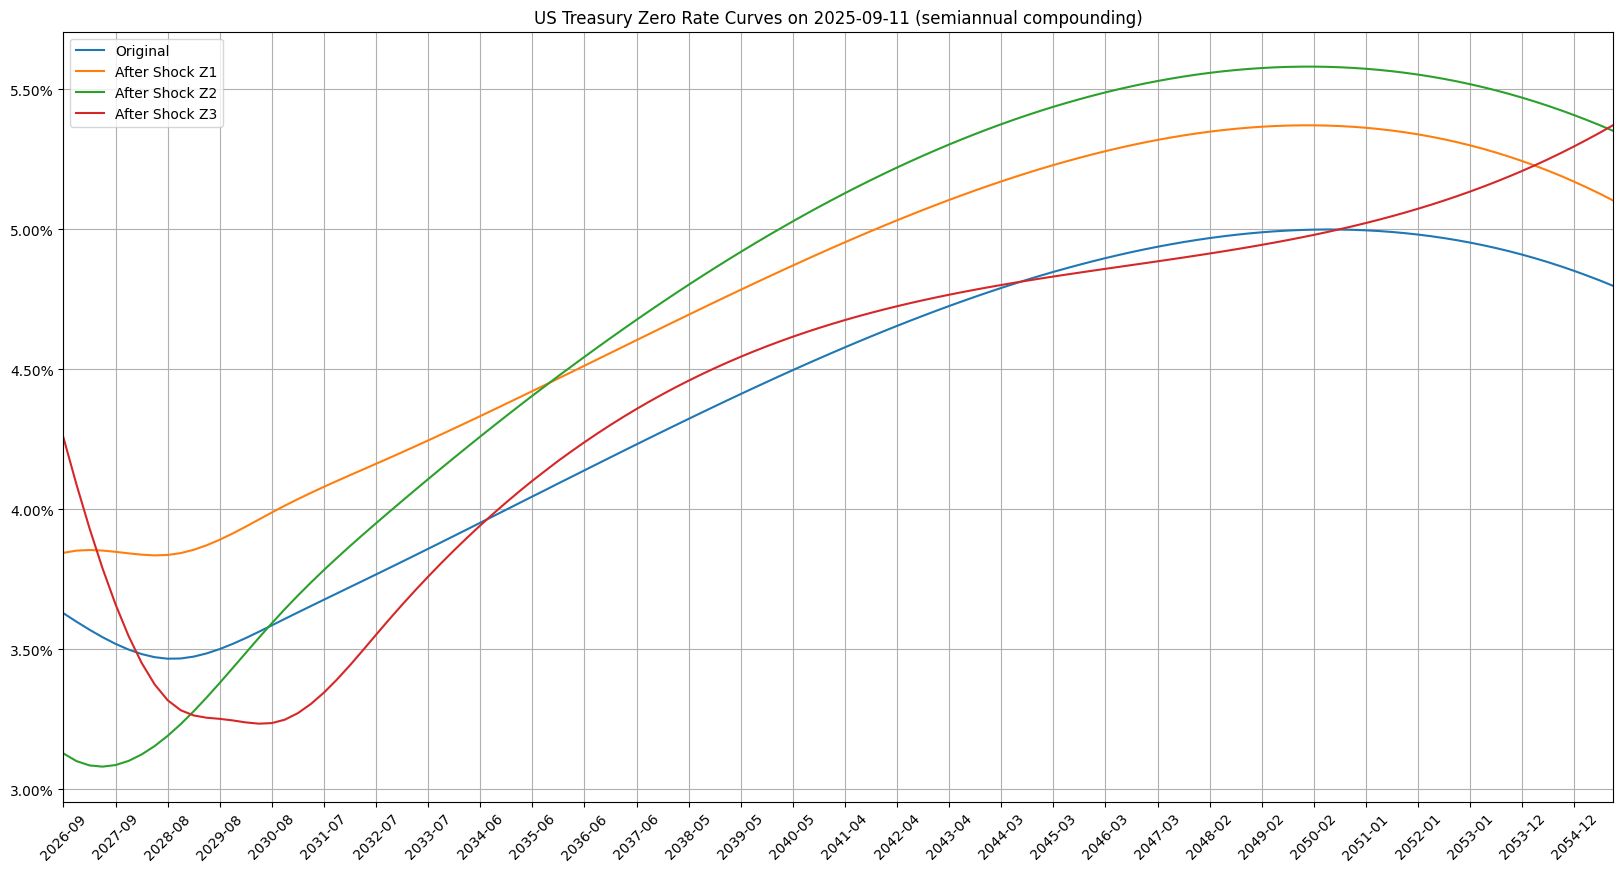

In [398]:
ax = curve_points.plot(figsize=(20,10), grid=True, xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
curve_points_z1.plot(figsize=(20,10), grid=True, xlim=(curve_points_z1.index[0], curve_points_z1.index[-1]),
                     xticks=curve_points_z1.index[::4], xlabel='', rot=45)
curve_points_z2.plot(figsize=(20,10), grid=True, xlim=(curve_points_z2.index[0], curve_points_z2.index[-1]),
                     xticks=curve_points_z2.index[::4], xlabel='', rot=45)
curve_points_z3.plot(figsize=(20,10), grid=True, xlim=(curve_points_z3.index[0], curve_points_z3.index[-1]),
                     xticks=curve_points_z3.index[::4], xlabel='', rot=45)
ax.set_title(f'US Treasury Zero Rate Curves on {cur_date_curve:%Y-%m-%d} (semiannual compounding)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
h, _ = ax.get_legend_handles_labels()
ax.legend(h, ['Original', 'After Shock Z1', 'After Shock Z2', 'After Shock Z3'])
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))